In [66]:
from timeit import timeit
from random import shuffle
import pandas as pd
import datetime
import numpy as np

In [14]:
def indexes_naive(lst, target):      
    for item_i, item1 in enumerate(lst):
        for item_j, item2 in enumerate(lst):
            if item_i != item_j and item1 + item2 == target:
                return [item_i, item_j]

In [16]:
def indexes_in (lst, target):
	for i, val in enumerate(lst):
		if (target - val) in lst and i != lst.index(target - val):
			return [i, lst.index(target - val)]

In [17]:
nums = [15, 2, 7, 11, 8]
target = 9
print(indexes_naive(nums, target))
print(indexes_in(nums, target))

[1, 2]
[1, 2]
[1, 2]


In [68]:
# словарь, ключ - длина списка без двух элементов, значение - список с двумя таймингами
timings = {}
for i in range(2, 13):
    timings[2**i] = [0, 0]
    
# print(timings)
# Мы будем использовать значения 2 и 7, а остальные - нули

repeats = 10 # сколько перестановок делать
local_repeats = 5 # количество повторений с одинаковым списком

for n in timings:
	print(datetime.datetime.now(), ": n =", n)
	curr = [2, 7] + [0]*n 
	for _ in range(100):
		shuffle(curr)
		# print(curr)
		timings[n][0] += timeit(lambda: indexes_naive(curr, target), number = local_repeats)
		timings[n][1] += timeit(lambda: indexes_in(curr, target), number = local_repeats)
  
	timings[n][0] /= local_repeats*repeats
	timings[n][1] /= local_repeats*repeats

timings

2021-12-16 01:23:41.137454 : n = 4
2021-12-16 01:23:41.157418 : n = 8
2021-12-16 01:23:41.183711 : n = 16
2021-12-16 01:23:41.218042 : n = 32
2021-12-16 01:23:41.275640 : n = 64
2021-12-16 01:23:41.437327 : n = 128
2021-12-16 01:23:42.050113 : n = 256
2021-12-16 01:23:44.056383 : n = 512
2021-12-16 01:23:51.981163 : n = 1024
2021-12-16 01:24:31.515005 : n = 2048
2021-12-16 01:26:35.828347 : n = 4096


{4: [1.9644300045911223e-05, 1.2177169774076901e-05],
 8: [4.6603270238847475e-05, 1.758995967975352e-05],
 16: [0.00010958259968901985, 2.9690470473724417e-05],
 32: [0.0003217801699065603, 6.48102300328901e-05],
 64: [0.0011888629298482556, 0.00019977404001110698],
 128: [0.004992127519726637, 0.0007825358799163951],
 256: [0.01708116384994355, 0.0025095695098571015],
 512: [0.06958129496044421, 0.009035939710083768],
 1024: [0.3515338666791649, 0.04302220692989067],
 2048: [1.1078469314607355, 0.13402593689963396],
 4096: [4.043115154280095, 0.47927706563001266]}

In [72]:
res = pd.DataFrame(timings).transpose().reset_index()
res.columns = ['n', 'indexes_naive', 'indexes_in']
res['ratio'] = res['indexes_naive']/res['indexes_in']
res

,n,indexes_naive,indexes_in,ratio
0,4,0.000020,0.000012,1.613207
1,8,0.000047,0.000018,2.649425
2,16,0.000110,0.000030,3.690834
3,32,0.000322,0.000065,4.964960
4,64,0.001189,0.000200,5.951038
5,128,0.004992,0.000783,6.379423
6,256,0.017081,0.002510,6.806412
7,512,0.069581,0.009036,7.700505
8,1024,0.351534,0.043022,8.170986
9,2048,1.107847,0.134026,8.265914


<AxesSubplot:xlabel='n'>

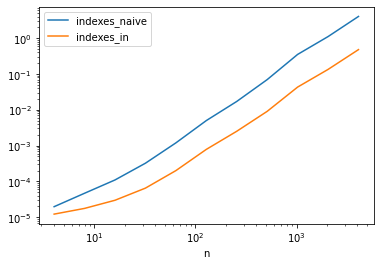

In [73]:
res.plot(x = "n", y = ["indexes_naive", "indexes_in"], loglog = True)